In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad

print(torch.cuda.device_count())
cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")
data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


2
NVIDIA A30
(872, 4500, 14) (872,)


# Multivariate Anomaly Detection GAN

Rewrite, because MADGAN use LSTM

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_features):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_features)

    def forward(self, z):
        h, _ = self.lstm(z)
        out = self.fc(h)
        return out


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.fc(h[:, -1, :])  # Use last hidden state
        return out
    

# Utility functions
def sample_Z(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim).to(device)

def sample_T(data, start_idx, batch_size):
    real_samples = torch.tensor(data[start_idx:start_idx + batch_size], dtype=torch.float32).to(device)
    return real_samples

def gan_loss(discriminator, real_data, fake_data, criterion):
    real_validity = discriminator(real_data)
    fake_validity = discriminator(fake_data.detach())
    real_targets = torch.ones_like(real_validity)
    fake_targets = torch.zeros_like(fake_validity)
    d_loss = criterion(real_validity, real_targets) + criterion(fake_validity, fake_targets)

    fake_validity_for_g = discriminator(fake_data)
    g_loss = criterion(fake_validity_for_g, real_targets)
    return d_loss, g_loss

# Multivariate Anomaly Detection GAN Training

In [3]:
# Training parameters
epochs = 25
n_classes = 2  # Assuming binary classification
batch_size = 64

# Initialize models
latent_dim = 100
hidden_dim = 128
num_features = 14 

generator = Generator(latent_dim, hidden_dim, num_features).to(device)
discriminator = Discriminator(num_features, hidden_dim).to(device)

# Optimizers
adversarial_loss = nn.BCEWithLogitsLoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.009)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005)

# Training loop
for epoch in range(epochs):
    for i in range(0, len(normal_data), batch_size):
        # Prepare real data
        real_data = torch.tensor(normal_data[i:i+batch_size], dtype=torch.float32).to(device)
        current_batch_size = real_data.size(0)
        # Ensure real_data is 3D: (batch, seq_len, num_features)
        if real_data.dim() == 2:
            real_data = real_data.unsqueeze(1)  # Add seq_len=1 if missing

        # Sample noise
        z = torch.randn(current_batch_size, real_data.size(1), latent_dim).to(device)
        # Generate fake data
        fake_data = generator(z)

        # Adversarial ground truths
        valid = torch.ones(current_batch_size, 1).to(device)
        fake = torch.zeros(current_batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_pred = discriminator(real_data)
        fake_pred = discriminator(fake_data.detach())
        d_real_loss = adversarial_loss(real_pred, valid)
        d_fake_loss = adversarial_loss(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        gen_pred = discriminator(fake_data)
        g_loss = adversarial_loss(gen_pred, valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 1/25 | D Loss: 0.8122 | G Loss: 0.3882
Epoch 2/25 | D Loss: 0.8635 | G Loss: 0.3380
Epoch 3/25 | D Loss: 0.8564 | G Loss: 0.3359
Epoch 4/25 | D Loss: 0.8138 | G Loss: 0.3614
Epoch 5/25 | D Loss: 0.7703 | G Loss: 0.3974
Epoch 6/25 | D Loss: 0.7305 | G Loss: 0.4422
Epoch 7/25 | D Loss: 0.6612 | G Loss: 0.5149
Epoch 8/25 | D Loss: 0.6513 | G Loss: 0.5256
Epoch 9/25 | D Loss: 0.6468 | G Loss: 0.5298
Epoch 10/25 | D Loss: 0.6179 | G Loss: 0.5677
Epoch 11/25 | D Loss: 0.6023 | G Loss: 0.5895
Epoch 12/25 | D Loss: 0.5701 | G Loss: 0.6420
Epoch 13/25 | D Loss: 0.5145 | G Loss: 0.7444
Epoch 14/25 | D Loss: 0.5060 | G Loss: 0.7580
Epoch 15/25 | D Loss: 0.4921 | G Loss: 0.7811
Epoch 16/25 | D Loss: 0.4752 | G Loss: 0.8149
Epoch 17/25 | D Loss: 0.4558 | G Loss: 0.8615
Epoch 18/25 | D Loss: 0.4405 | G Loss: 0.8978
Epoch 19/25 | D Loss: 0.4840 | G Loss: 0.7771
Epoch 20/25 | D Loss: 0.6010 | G Loss: 0.5695
Epoch 21/25 | D Loss: 0.6143 | G Loss: 0.5363
Epoch 22/25 | D Loss: 0.6288 | G Loss: 0.51

# Generate and Combine

In [4]:
generator.eval()

num_samples = len(data[label == 0])  # Number of synthetic samples to generate
batch_size = 16  # Reduce batch size to avoid OOM
seq_len = 4500

generated_batches = []
with torch.no_grad():
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        current_batch_size = end - start
        z = torch.randn(current_batch_size, seq_len, latent_dim, device=device)
        batch_generated = generator(z)
        generated_batches.append(batch_generated.cpu())  # Move to CPU to save GPU memory

generated_data = torch.cat(generated_batches, dim=0).numpy()

# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(num_samples), normal_label), axis=0)


# Processing: Mel Spec > Resizing > Feature Extraction

In [5]:
# Resize and convert to 3-channel image
def resize_spectrogram(spectrogram):
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

# Process dataset
def process_dataset(data):
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=2500000, n_mels=128).to(device)
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()

    for i in range(num_samples):
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            img = resize_spectrogram(mel)
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    return features

# AE Class

In [ ]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data):
    model.eval()
    x = torch.tensor(data.reshape(-1, 4096), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    loss = []
    criterion = torch.nn.MSELoss(reduction='none')
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            loss.extend(batch_errors.cpu().numpy())
    return np.array(loss)

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    # Step 1: Flatten the test data
    n_samples, n_segments, n_features = X_test.shape
    X_test_flat = X_test.reshape(-1, n_features)

    # Step 2: Compute reconstruction errors per segment
    segment_errors = compute_reconstruction_loss(model, X_test_flat)

    # Step 3: Aggregate errors per sample (mean over segments)
    sample_errors = segment_errors.reshape(n_samples, n_segments).mean(axis=1)

    # Step 4: Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(sample_errors.min(), sample_errors.max(), 100):
        preds = (sample_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Step 5: Predict using best threshold
    test_preds = (sample_errors > best_threshold).astype(int)

    # Step 6: Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))



# Preprocessing

In [7]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = StandardScaler().fit_transform(combine_data.reshape(-1, combine_data.shape[-1])).reshape(combine_data.shape)
features = process_dataset(scaled_data)
print("Features shape:", features.shape)

/home/chris/GANs/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Features shape: (1562, 14, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 0.684130
Epoch 2/15, Loss: 0.630980
Epoch 3/15, Loss: 0.630964
Epoch 4/15, Loss: 0.630943
Epoch 5/15, Loss: 0.630885
Epoch 6/15, Loss: 0.630908
Epoch 7/15, Loss: 0.630917
Epoch 8/15, Loss: 0.630916
Epoch 9/15, Loss: 0.630940
Epoch 10/15, Loss: 0.630907
Epoch 11/15, Loss: 0.630923
Epoch 12/15, Loss: 0.630919
Epoch 13/15, Loss: 0.630881
Epoch 14/15, Loss: 0.630856
Epoch 15/15, Loss: 0.630868
Best threshold: 0.6204198484468941, Best F1 Score: 0.18560133166874743


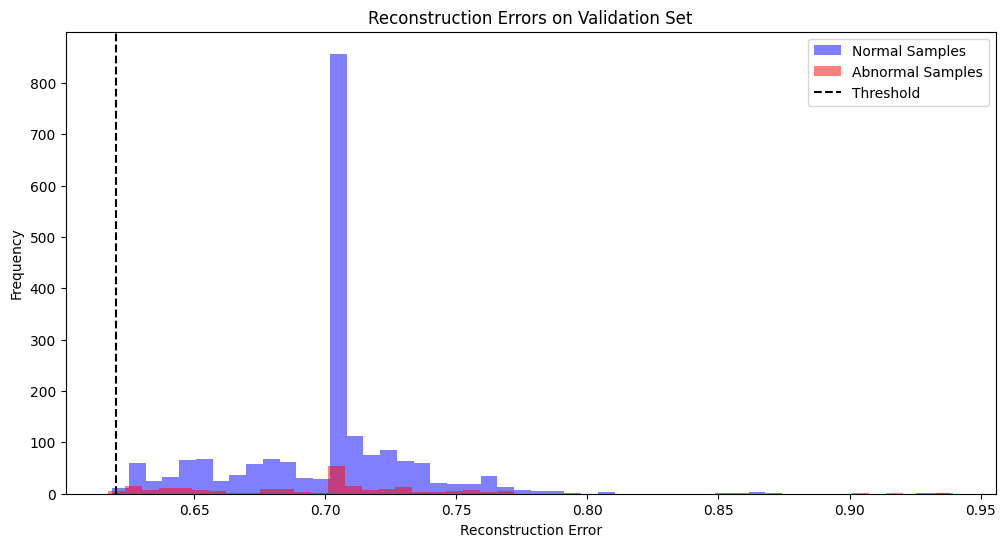

Best Threshold = 0.665825, Best F1 Score = 0.2260
Evaluation on Test Set:
Accuracy = 0.12738853503184713
Precision = 0.1282051282051282
Recall = 0.9523809523809523
F1 Score = 0.22598870056497172
Confusion Matrix:
 [[  0 136]
 [  1  20]]
Fold 2
Epoch 1/15, Loss: 0.674508
Epoch 2/15, Loss: 0.630097
Epoch 3/15, Loss: 0.621072
Epoch 4/15, Loss: 0.620107
Epoch 5/15, Loss: 0.619766
Epoch 6/15, Loss: 0.619705
Epoch 7/15, Loss: 0.619608
Epoch 8/15, Loss: 0.619520
Epoch 9/15, Loss: 0.619449
Epoch 10/15, Loss: 0.619450
Epoch 11/15, Loss: 0.619268
Epoch 12/15, Loss: 0.619270
Epoch 13/15, Loss: 0.619207
Epoch 14/15, Loss: 0.619146
Epoch 15/15, Loss: 0.618920
Best threshold: 0.6011219277526393, Best F1 Score: 0.18708053691275167


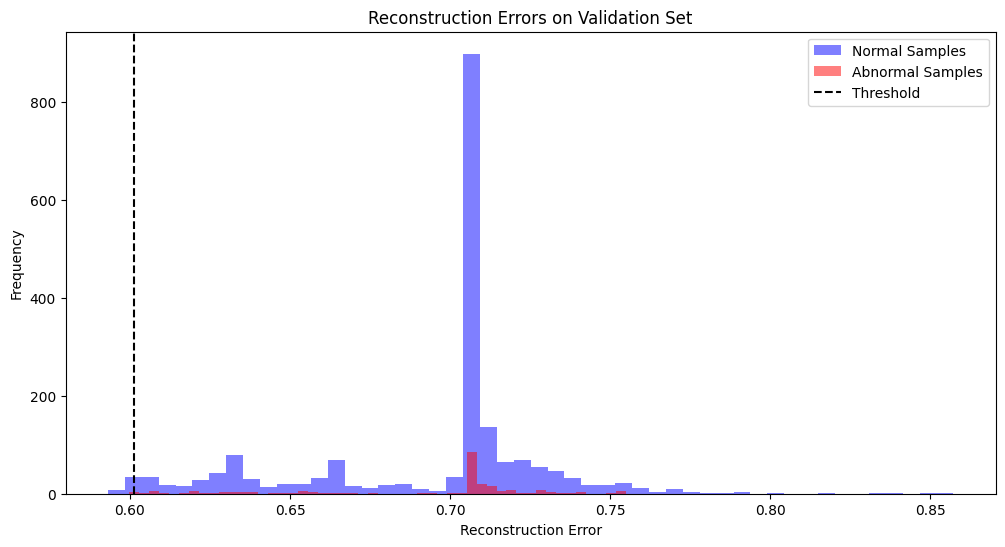

Best Threshold = 0.666363, Best F1 Score = 0.2260
Evaluation on Test Set:
Accuracy = 0.12738853503184713
Precision = 0.1282051282051282
Recall = 0.9523809523809523
F1 Score = 0.22598870056497172
Confusion Matrix:
 [[  0 136]
 [  1  20]]
Fold 3
Epoch 1/15, Loss: 0.681311
Epoch 2/15, Loss: 0.627000
Epoch 3/15, Loss: 0.618483
Epoch 4/15, Loss: 0.616865
Epoch 5/15, Loss: 0.616377
Epoch 6/15, Loss: 0.615968
Epoch 7/15, Loss: 0.615319
Epoch 8/15, Loss: 0.614794
Epoch 9/15, Loss: 0.614170
Epoch 10/15, Loss: 0.613358
Epoch 11/15, Loss: 0.612775
Epoch 12/15, Loss: 0.612352
Epoch 13/15, Loss: 0.611976
Epoch 14/15, Loss: 0.611846
Epoch 15/15, Loss: 0.611647
Best threshold: 0.5987633418555212, Best F1 Score: 0.22906403940886702


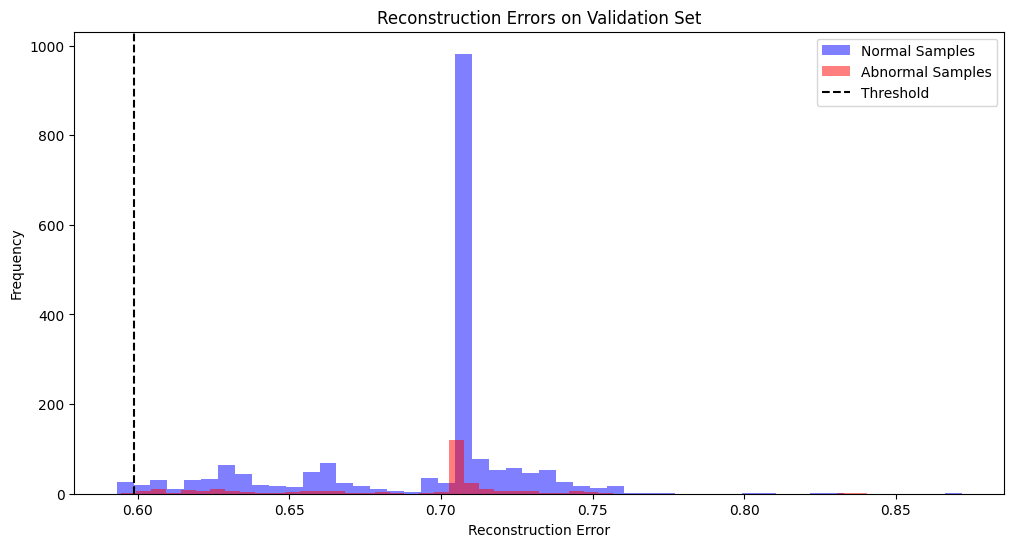

Best Threshold = 0.710063, Best F1 Score = 0.1818
Evaluation on Test Set:
Accuracy = 0.8269230769230769
Precision = 0.17647058823529413
Recall = 0.1875
F1 Score = 0.1818181818181818
Confusion Matrix:
 [[126  14]
 [ 13   3]]
Fold 4
Epoch 1/15, Loss: 0.680725
Epoch 2/15, Loss: 0.630763
Epoch 3/15, Loss: 0.621822
Epoch 4/15, Loss: 0.619880
Epoch 5/15, Loss: 0.619548
Epoch 6/15, Loss: 0.619386
Epoch 7/15, Loss: 0.619295
Epoch 8/15, Loss: 0.619242
Epoch 9/15, Loss: 0.619169
Epoch 10/15, Loss: 0.619154
Epoch 11/15, Loss: 0.619079
Epoch 12/15, Loss: 0.618969
Epoch 13/15, Loss: 0.618915
Epoch 14/15, Loss: 0.618560
Epoch 15/15, Loss: 0.617915
Best threshold: 0.6015658655551949, Best F1 Score: 0.22859483818107332


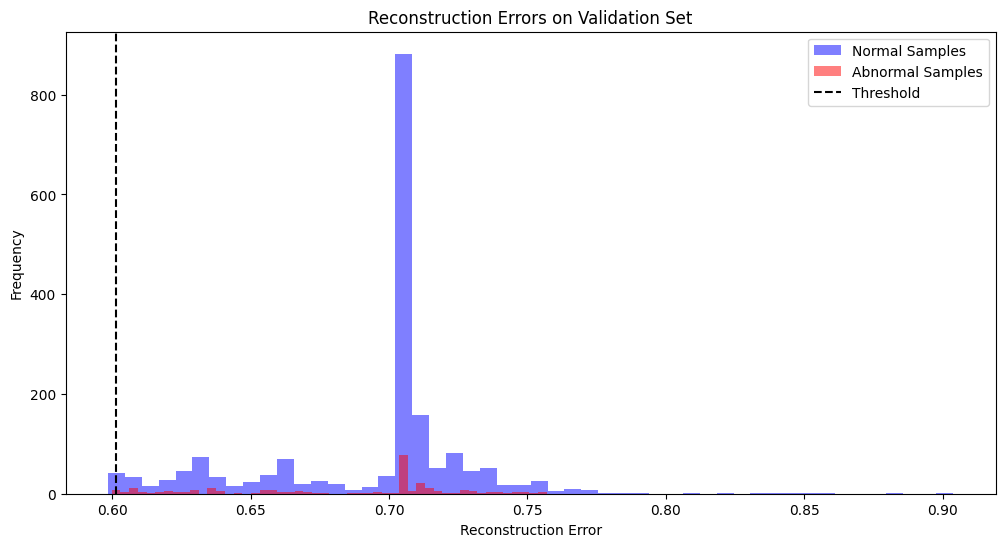

Best Threshold = 0.712050, Best F1 Score = 0.2759
Evaluation on Test Set:
Accuracy = 0.8653846153846154
Precision = 0.3076923076923077
Recall = 0.25
F1 Score = 0.27586206896551724
Confusion Matrix:
 [[131   9]
 [ 12   4]]
Fold 5
Epoch 1/15, Loss: 0.692903
Epoch 2/15, Loss: 0.631019
Epoch 3/15, Loss: 0.630971
Epoch 4/15, Loss: 0.630971
Epoch 5/15, Loss: 0.630957
Epoch 6/15, Loss: 0.630941
Epoch 7/15, Loss: 0.630933
Epoch 8/15, Loss: 0.630937
Epoch 9/15, Loss: 0.630920
Epoch 10/15, Loss: 0.630922
Epoch 11/15, Loss: 0.630915
Epoch 12/15, Loss: 0.630903
Epoch 13/15, Loss: 0.630917
Epoch 14/15, Loss: 0.630911
Epoch 15/15, Loss: 0.630900
Best threshold: 0.6193410158157349, Best F1 Score: 0.22655298416565162


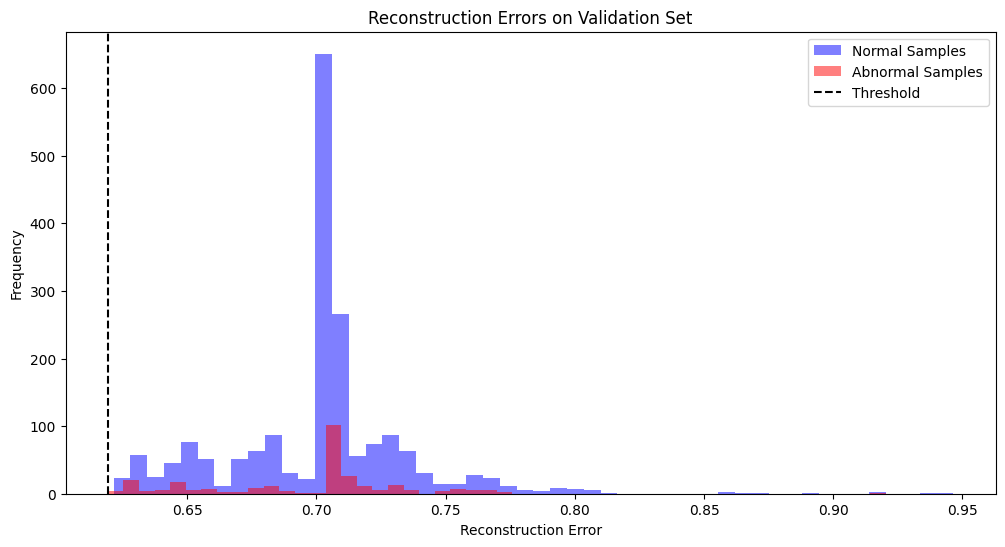

Best Threshold = 0.705921, Best F1 Score = 0.1765
Evaluation on Test Set:
Accuracy = 0.6410256410256411
Precision = 0.11538461538461539
Recall = 0.375
F1 Score = 0.1764705882352941
Confusion Matrix:
 [[94 46]
 [10  6]]


In [8]:

for fold, (train_idx, val_idx) in enumerate(skf.split(features, combine_label)):
    
    print(f"Fold {fold + 1}")
    
    # Get full fold data
    fold_data, fold_labels = features[train_idx], combine_label[train_idx]
    val_data, val_labels = features[val_idx], combine_label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=42)

    # Train autoencoder on the training fold
    model = train_autoencoder(X_train[y_train == 0], epochs=15, batch_size=32)

    # Evaluate on validation fold
    val_errors_normal = compute_reconstruction_loss(model, X_val[y_val == 0])
    val_errors_abnormal = compute_reconstruction_loss(model, X_val[y_val == 1])
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    

    val_errors_test = compute_reconstruction_loss(model, X_test)
    

    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)



# Observation:

Accuracy = 0.9142857142857143

Precision = 0.6

Recall = 0.35294117647058826

F1 Score = 0.4444444444444445

Confusion Matrix:

 [[154   4]
 
 [ 11   6]]



